# Analysis of AudioSeal watermark resistance to basic audio processing

In [1]:
import numpy as np
import librosa
import scipy.signal
from pydub import AudioSegment
import matplotlib.pyplot as plt
import seaborn as sns
import typing as tp
import torch
import torchaudio
import pandas as pd
import glob
from tqdm import tqdm
import soundfile as sf
import io

## Defining audio manipulation functions

In [2]:

def apply_lossy_compression(audio, sample_rate):
    with io.BytesIO() as inmemoryfile:
        audio_segment = AudioSegment(
            audio.tobytes(), 
            frame_rate=sample_rate,
            sample_width=audio.dtype.itemsize, 
            channels=1
        )
        audio_segment.export(inmemoryfile, format="mp3")
        return np.array(AudioSegment.from_file_using_temporary_files(inmemoryfile)
                       .get_array_of_samples())

def apply_lossless_compression(audio, sample_rate):
    with io.BytesIO() as inmemoryfile:
        audio_segment = AudioSegment(
            audio.tobytes(), 
            frame_rate=sample_rate,
            sample_width=audio.dtype.itemsize, 
            channels=1
        )
        audio_segment.export(inmemoryfile, format="flac")
        return np.array(AudioSegment.from_file_using_temporary_files(inmemoryfile)
                       .get_array_of_samples())

def add_noise(audio, noise_type="white", noise_level=0.01):
    if noise_type == "white":
        noise = np.random.normal(0, noise_level, audio.shape)
    elif noise_type == "gaussian":
        noise = np.random.normal(0, noise_level * np.std(audio), audio.shape)
    else:
        raise ValueError("Unsupported noise type")
    return audio + noise

def apply_filter(audio, sample_rate, filter_type="lowpass", cutoff=3000):
    nyquist = 0.5 * sample_rate
    if filter_type == "lowpass":
        normal_cutoff = cutoff / nyquist
        b, a = scipy.signal.butter(5, normal_cutoff, btype='low')
    elif filter_type == "highpass":
        normal_cutoff = cutoff / nyquist
        b, a = scipy.signal.butter(5, normal_cutoff, btype='high')
    elif filter_type == "bandpass":
        low, high = cutoff
        normal_cutoff = [low / nyquist, high / nyquist]
        b, a = scipy.signal.butter(5, normal_cutoff, btype='band')
    else:
        raise ValueError("Unsupported filter type")
    return scipy.signal.lfilter(b, a, audio)

def resample_audio(audio, original_sr, target_sr):
    return librosa.resample(audio, orig_sr=original_sr, target_sr=target_sr)

def equalize_audio(audio, sample_rate):
    # Simple equalization: Apply a filter to simulate equalization
    b, a = scipy.signal.butter(3, 1000 / (0.5 * sample_rate), btype='high')
    equalized_audio = scipy.signal.lfilter(b, a, audio)
    return equalized_audio

def add_reverb(audio, sample_rate, reverberance=50):
    reverb_audio = librosa.effects.preemphasis(audio)
    return reverb_audio

def time_scale_modification(audio, rate):
    return librosa.effects.time_stretch(audio, rate=rate)

def pitch_shift(audio, sample_rate, n_steps):
    return librosa.effects.pitch_shift(audio, sr=sample_rate, n_steps=n_steps)

def dynamic_range_compression(audio):
    return librosa.effects.percussive(audio)

def clip_audio(audio, threshold=0.8):
    return np.clip(audio, -threshold, threshold)

In [3]:
from audioseal import AudioSeal
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

secret_message = torch.randint(0, 2, (1, 16), dtype=torch.int32)
secret_message = secret_message.to(device)
print(f"Secret message: {secret_message}")


model = AudioSeal.load_generator("audioseal_wm_16bits")
detector = AudioSeal.load_detector("audioseal_detector_16bits")


model = model.to(device)
detector = detector.to(device)

def generate_watermark_audio(
    tensor: torch.Tensor,
    sample_rate: int
) -> tp.Optional[torch.Tensor]:
    try:
        global model, device, secret_message
        audios = tensor.unsqueeze(0).to(device)
        watermarked_audio = model(audios, sample_rate=sample_rate, message=secret_message.to(device), alpha=1)
        return watermarked_audio

    
    except Exception as e:
        print(f"Error while watermarking audio: {e}")
        return None

# Function to get the confidence score that an audio tensor was watermarked by Audioseal
# provided by the Audioseal team
def detect_watermark_audio(
    tensor: torch.Tensor,
    sample_rate: int,
    message_threshold: float = 0.50
) -> tp.Optional[float]:
    try:
        global detector, device
        # In our analysis we are not concerned with the hidden/embedded message as of now
        result, _ = detector.detect_watermark(tensor, sample_rate=sample_rate, message_threshold=message_threshold)
        return float(result)
    except Exception as e:
        print(f"Error while detecting watermark: {e}")
        return None

Using device: cuda
Secret message: tensor([[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]], device='cuda:0',
       dtype=torch.int32)


## Loading the audio samples

In [4]:
# Load metadata and audio samples from CREMA-D dataset
def load_crema_d_metadata(metadata_path):
    df = pd.read_csv(metadata_path)
    return df

def load_audio_samples(actor_id, base_path):
    file_paths = []
    # find all audio files starting with the actor_id
    for file_path in glob.glob(f"{base_path}/{actor_id}*.wav"):
        file_paths.append(file_path)
    
    audio_samples = []

    for file_path in file_paths:
        audio, sr = load_audio_sample(file_path)
        audio_samples.append((audio, sr, file_path))
    
    return audio_samples
    



def load_audio_sample(
    file_path: str
) -> tp.Optional[tp.Tuple[torch.Tensor, int]]:
    try:
        wav, sample_rate = torchaudio.load(file_path)
        return wav, sample_rate
    except Exception as e:
        print(f"Error while loading audio: {e}")
        return None

In [5]:
def filter_samples(df, emotions, levels, genders, races, ethnicities):
    filtered_df = df[
        df['Emotion'].isin(emotions) &
        df['Emotion_Level'].isin(levels) &
        df['Gender'].isin(genders) &
        df['Race'].isin(races) &
        df['Ethnicity'].isin(ethnicities)
    ]
    return filtered_df

## Expertiment setup

In [6]:
# Define the list of manipulations
manipulations = [
    ('Lossy Compression', apply_lossy_compression),
    ('Lossless Compression', apply_lossless_compression),
    ('White Noise Addition', lambda audio, _: add_noise(audio, "white")),
    ('Gaussian Noise Addition', lambda audio, _: add_noise(audio, "gaussian")),
    ('Low-pass Filter', lambda audio, sr: apply_filter(audio, sr, "lowpass")),
    ('High-pass Filter', lambda audio, sr: apply_filter(audio, sr, "highpass")),
    ('Band-pass Filter', lambda audio, sr: apply_filter(audio, sr, "bandpass", cutoff=(300, 3000))),
    ('Downsampling', lambda audio, sr: resample_audio(audio, sr, sr // 2)),
    ('Upsampling', lambda audio, sr: resample_audio(audio, sr, sr * 2)),
    ('Equalization', equalize_audio),
    ('Reverberation', add_reverb),
    ('Time-Scale Modification', lambda audio, _: time_scale_modification(audio, 1.5)),
    ('Pitch Shifting', lambda audio, sr: pitch_shift(audio, sr, 2)),
    ('Dynamic Range Compression', lambda audio, _: dynamic_range_compression(audio)),
    ('Clipping', lambda audio, _: clip_audio(audio))
]

In [30]:
def perform_experiment(df, base_path):
    results = []
    for index, row in tqdm(df.iterrows(), total=len(df)):
        try:
            audio_sr = load_audio_samples(row['ActorID'], base_path)
        except Exception as e:
            print(f"Error while loading audio samples: {e}")
            continue
        
        for audio, sr, fp in audio_sr:
            audio = generate_watermark_audio(audio, sr)
            # open audio with librosa
            original_score = detect_watermark_audio(audio, sr)

            audio_np = audio.detach().cpu().numpy().squeeze()
            if audio_np.ndim == 1:
                audio_np = np.expand_dims(audio_np, axis=0)  # Ensure 2D shape (channels, samples)
            audio_path = "temp_audio.wav"
            sf.write(audio_path, audio_np.T, sr)  # Transpose to match (samples, channels) format
            
            audio_librosa, sr_librosa = librosa.load(audio_path, sr=sr)

            for name, manipulation in manipulations:
                manipulated_audio = manipulation(audio_librosa, sr_librosa)
                # save the manipulated audio to see the effect
                fname = fp.split('\\')[-1]
                manipulated_audio_path = f"{fname}_audio_{name}.wav"
                sf.write(manipulated_audio_path, manipulated_audio, sr_librosa)
                # convert numpy array to torch tensor
                manipulated_audio_tensor = torch.tensor(manipulated_audio).float().to(device)
                manipulated_audio_tensor = manipulated_audio_tensor.unsqueeze(0).unsqueeze(0)
                
           
                detection_score = detect_watermark_audio(manipulated_audio_tensor, sr)
                results.append({
                    'Emotion': fp.split('/')[-1].split('_')[2],
                    'Emotion_Level': fp.split('/')[-1].split('_')[3],
                    'Gender': row['Sex'],
                    'Race': row['Race'],
                    'Ethnicity': row['Ethnicity'],
                    'Manipulation': name,
                    'Detection Score': detection_score,
                    'Original Score': original_score
                })
    return results

def plot_results(results):
    df = pd.DataFrame(results)
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Manipulation', y='Detection Score', hue='Emotion', data=df)
    plt.xticks(rotation=90)
    plt.title('Watermark Detection Scores for Different Audio Manipulations by Emotion')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Manipulation', y='Detection Score', hue='Emotion_Level', data=df)
    plt.xticks(rotation=90)
    plt.title('Watermark Detection Scores for Different Audio Manipulations by Emotion Level')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Manipulation', y='Detection Score', hue='Gender', data=df)
    plt.xticks(rotation=90)
    plt.title('Watermark Detection Scores for Different Audio Manipulations by Gender')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Manipulation', y='Detection Score', hue='Race', data=df)
    plt.xticks(rotation=90)
    plt.title('Watermark Detection Scores for Different Audio Manipulations by Race')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Manipulation', y='Detection Score', hue='Ethnicity', data=df)
    plt.xticks(rotation=90)
    plt.title('Watermark Detection Scores for Different Audio Manipulations by Ethnicity')
    plt.tight_layout()
    plt.show()

    # plot the combined results for all manipulations despite the demographic information
    # sort the manipulations by the median detection score
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Manipulation', y='Detection Score', data=df, order=df.groupby('Manipulation')['Detection Score'].median().sort_values(ascending=False).index)
    plt.xticks(rotation=90)
    plt.title('Watermark Detection Scores for Different Audio Manipulations')
    plt.tight_layout()
    plt.show()

In [29]:
perform_experiment(filtered_metadata, base_audio_path)

  0%|          | 0/91 [00:12<?, ?it/s]


KeyboardInterrupt: 

In [16]:
# Main execution
metadata_path = '../../../../crema-d/VideoDemographics.csv'  # Placeholder path
base_audio_path = '../../../../crema-d'  # Placeholder path
crema_d_metadata = load_crema_d_metadata(metadata_path)

# Define filters
# emotions = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']
# levels = ['Low', 'Medium', 'High', 'Unspecified']
emotions = ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']
levels = ['LO', 'MD', 'HI', 'XX']
genders = ['Male', 'Female']
races = ['White', 'Black', 'Asian', 'Other']
ethnicities = ['Hispanic', 'Non-Hispanic']

# filtered_metadata = filter_samples(crema_d_metadata, emotions, levels, genders, races, ethnicities)
filtered_metadata = crema_d_metadata
experiment_results = perform_experiment(filtered_metadata, base_audio_path)

  1%|          | 1/91 [00:41<1:02:35, 41.73s/it]

Error while loading audio: Error opening '../../../../crema-d\\1002_DFA_FEA_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object


  4%|▍         | 4/91 [02:26<54:49, 37.81s/it]  

Error while loading audio: Error opening '../../../../crema-d\\1005_DFA_ANG_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object


  7%|▋         | 6/91 [03:17<44:45, 31.60s/it]

Error while loading audio: Error opening '../../../../crema-d\\1007_TSI_FEA_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object


  9%|▉         | 8/91 [04:07<39:56, 28.87s/it]

Error while loading audio: Error opening '../../../../crema-d\\1009_IEO_FEA_LO.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1010_DFA_NEU_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object


 14%|█▍        | 13/91 [04:53<20:14, 15.57s/it]

Error while loading audio: Error opening '../../../../crema-d\\1012_IOM_FEA_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1013_TAI_SAD_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1014_TAI_ANG_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object


 16%|█▋        | 15/91 [05:36<21:56, 17.32s/it]

Error while loading audio: Error opening '../../../../crema-d\\1016_ITS_FEA_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1017_IEO_FEA_LO.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object


 25%|██▌       | 23/91 [07:47<15:58, 14.10s/it]

Error while loading audio: Error opening '../../../../crema-d\\1021_IEO_ANG_MD.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1022_DFA_DIS_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1023_TIE_SAD_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1024_IOM_SAD_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1025_IWW_FEA_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object


 34%|███▍      | 31/91 [07:48<04:30,  4.51s/it]

Error while loading audio: Error opening '../../../../crema-d\\1026_DFA_FEA_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1027_DFA_ANG_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1028_DFA_ANG_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1029_DFA_HAP_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1030_IWL_ANG_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1031_IE

 43%|████▎     | 39/91 [07:48<01:41,  1.95s/it]

Error while loading audio: Error opening '../../../../crema-d\\1035_IWL_FEA_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1036_IEO_ANG_MD.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1037_IWW_ANG_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1038_IEO_HAP_MD.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1039_IEO_DIS_MD.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1040_IT

 52%|█████▏    | 47/91 [07:48<00:40,  1.09it/s]

Error while loading audio: Error opening '../../../../crema-d\\1042_ITH_DIS_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1043_IEO_DIS_MD.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1044_TAI_ANG_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1045_IEO_DIS_HI.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1046_IEO_FEA_HI.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1047_IW

 64%|██████▎   | 58/91 [07:48<00:12,  2.55it/s]

Error while loading audio: Error opening '../../../../crema-d\\1050_IEO_SAD_HI.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1051_DFA_DIS_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1052_DFA_DIS_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1053_DFA_NEU_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1054_MTI_FEA_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1055_IW

 67%|██████▋   | 61/91 [08:33<01:48,  3.62s/it]

Error while loading audio: Error opening '../../../../crema-d\\1062_DFA_HAP_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1063_IWL_DIS_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object


 76%|███████▌  | 69/91 [09:27<01:38,  4.49s/it]

Error while loading audio: Error opening '../../../../crema-d\\1065_IEO_FEA_LO.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1066_IEO_DIS_LO.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1067_IEO_DIS_HI.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1068_IEO_FEA_MD.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1069_IEO_FEA_LO.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1070_IT

 85%|████████▍ | 77/91 [09:27<00:31,  2.25s/it]

Error while loading audio: Error opening '../../../../crema-d\\1072_TSI_ANG_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1073_DFA_HAP_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1074_ITS_DIS_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1075_IEO_DIS_HI.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1076_TAI_HAP_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1077_DF

 93%|█████████▎| 85/91 [09:28<00:06,  1.13s/it]

Error while loading audio: Error opening '../../../../crema-d\\1079_IEO_NEU_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1080_ITH_SAD_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1081_DFA_NEU_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1082_ITS_ANG_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1083_ITH_DIS_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1084_IE

100%|██████████| 91/91 [10:14<00:00,  6.75s/it]

Error while loading audio: Error opening '../../../../crema-d\\1088_IOM_HAP_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1089_DFA_DIS_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1090_DFA_SAD_XX.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object
Error while loading audio: Error opening '../../../../crema-d\\1091_IEO_FEA_HI.wav': Format not recognised.
Error while loading audio samples: cannot unpack non-iterable NoneType object


In [17]:
# save results to a CSV file and pickle file
df = pd.DataFrame(experiment_results)
df.to_csv('experiment_results.csv', index=False)
df.to_pickle('experiment_results.pkl')

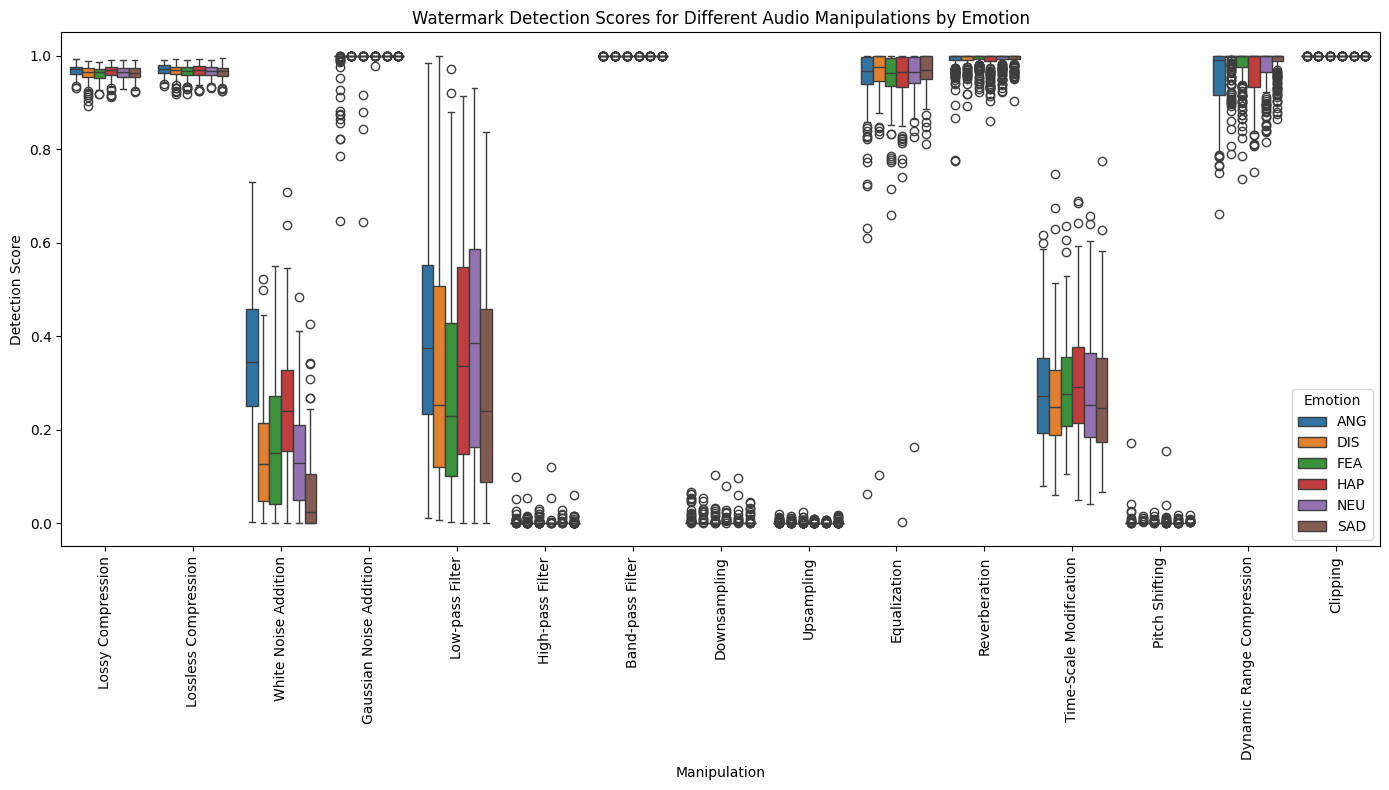

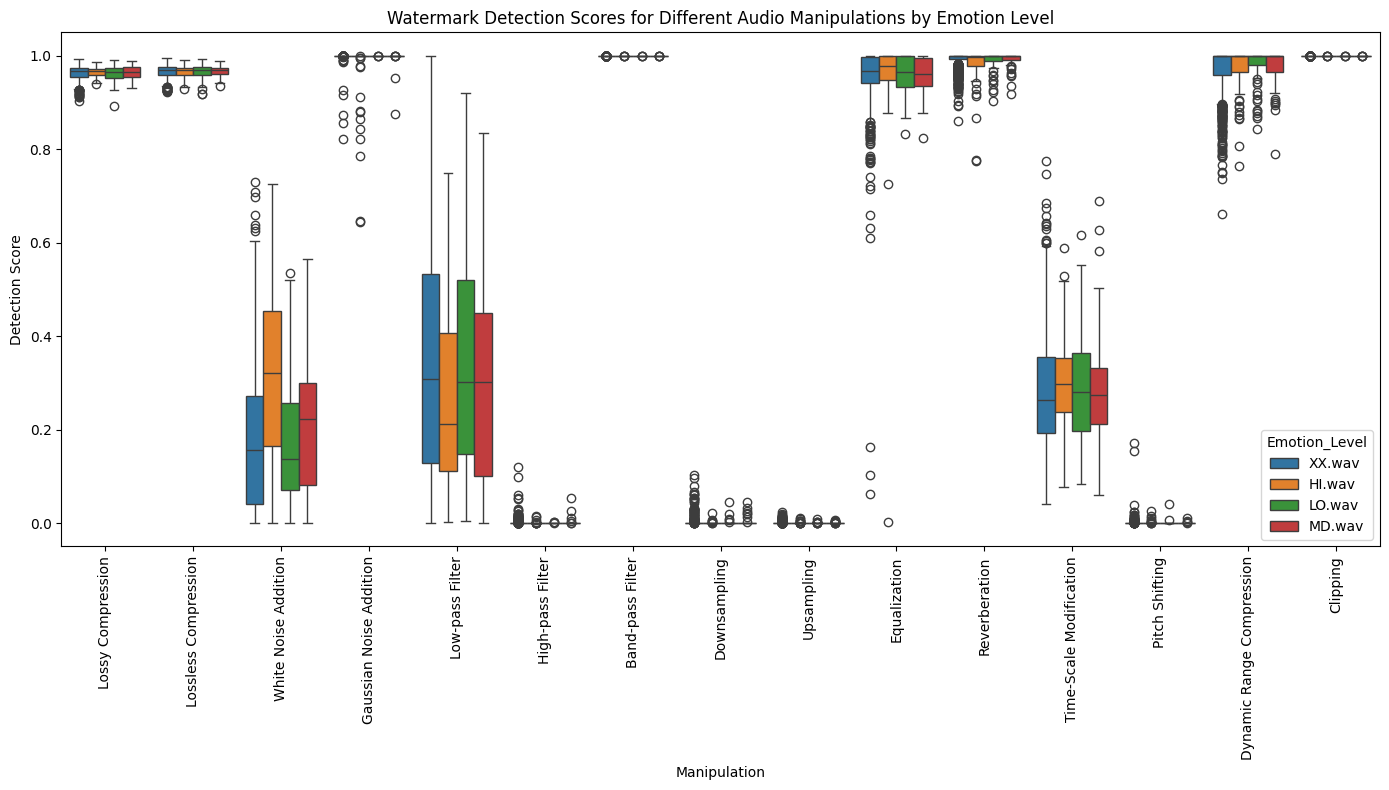

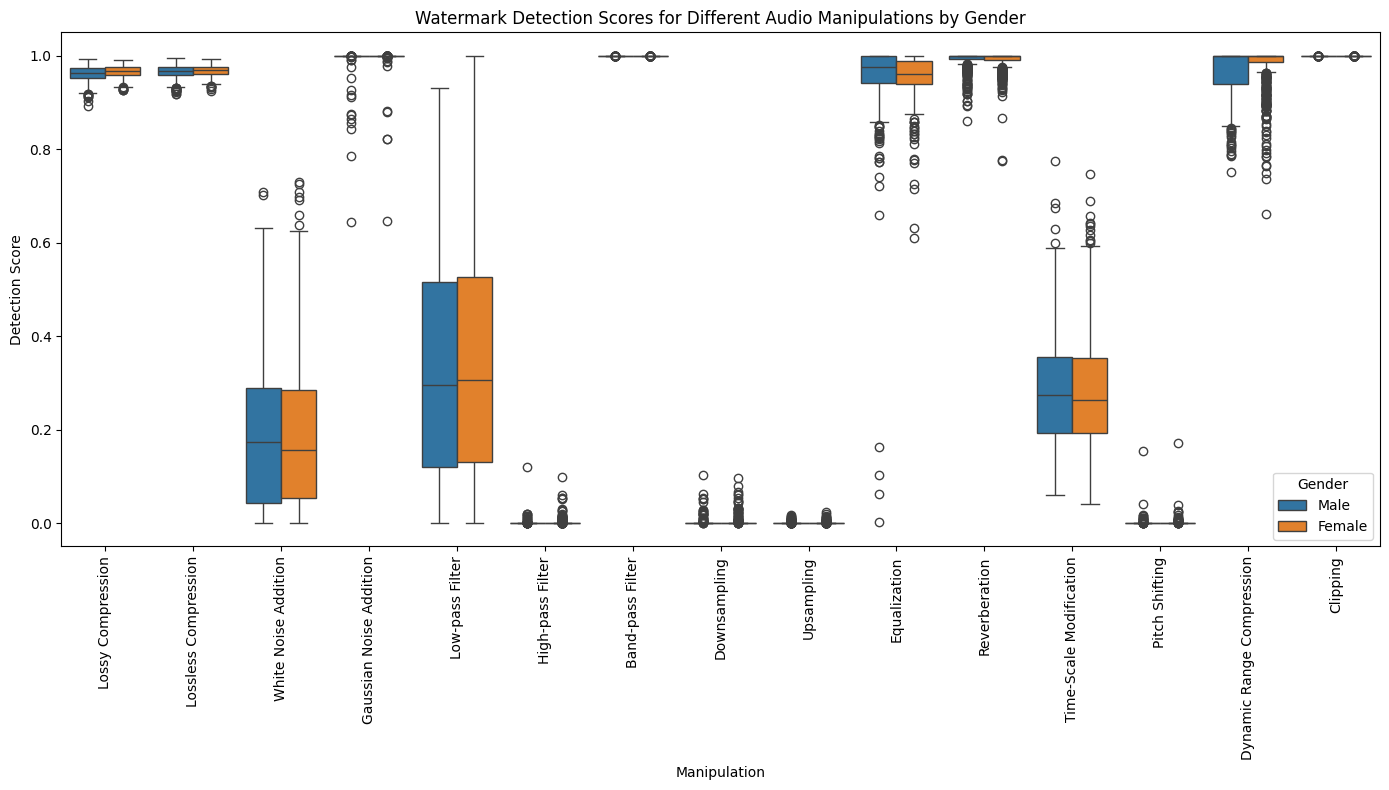

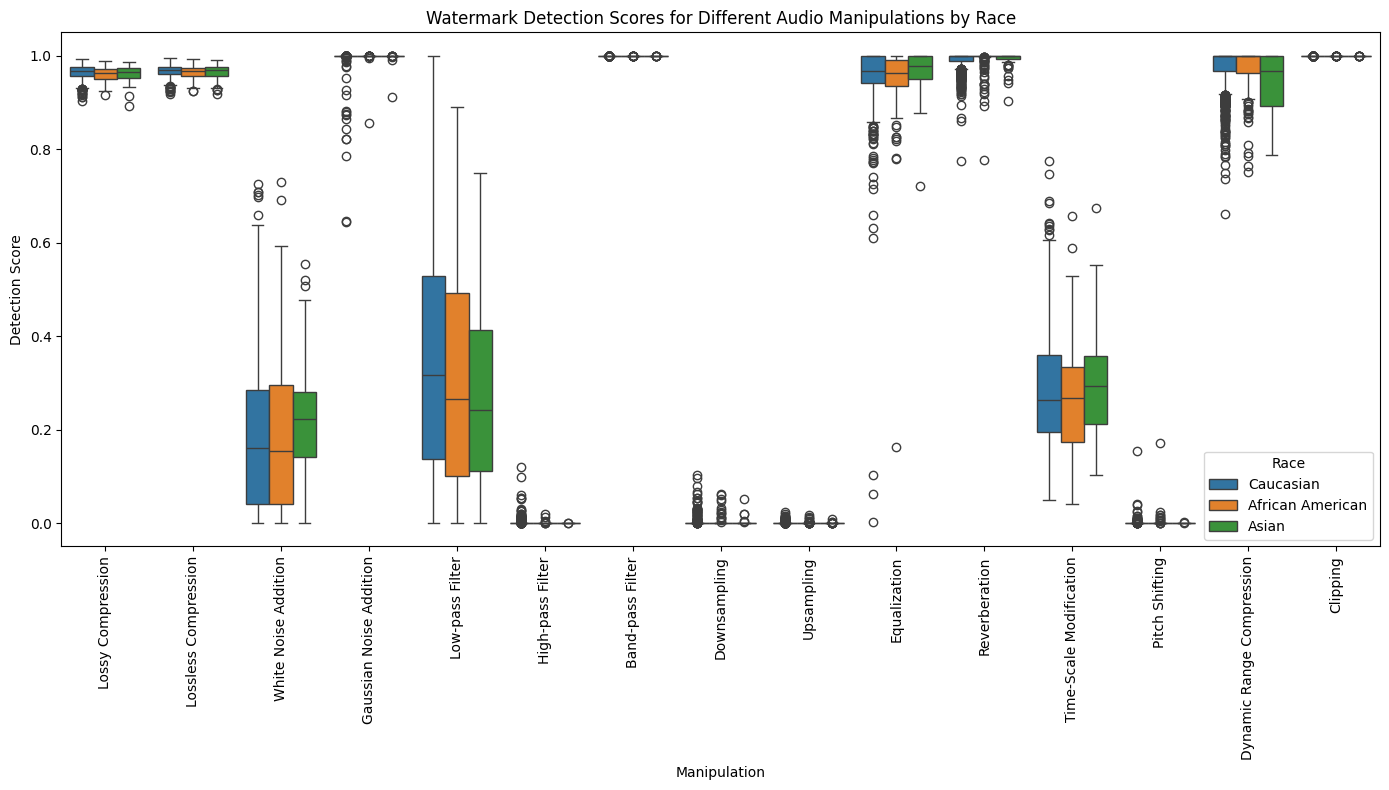

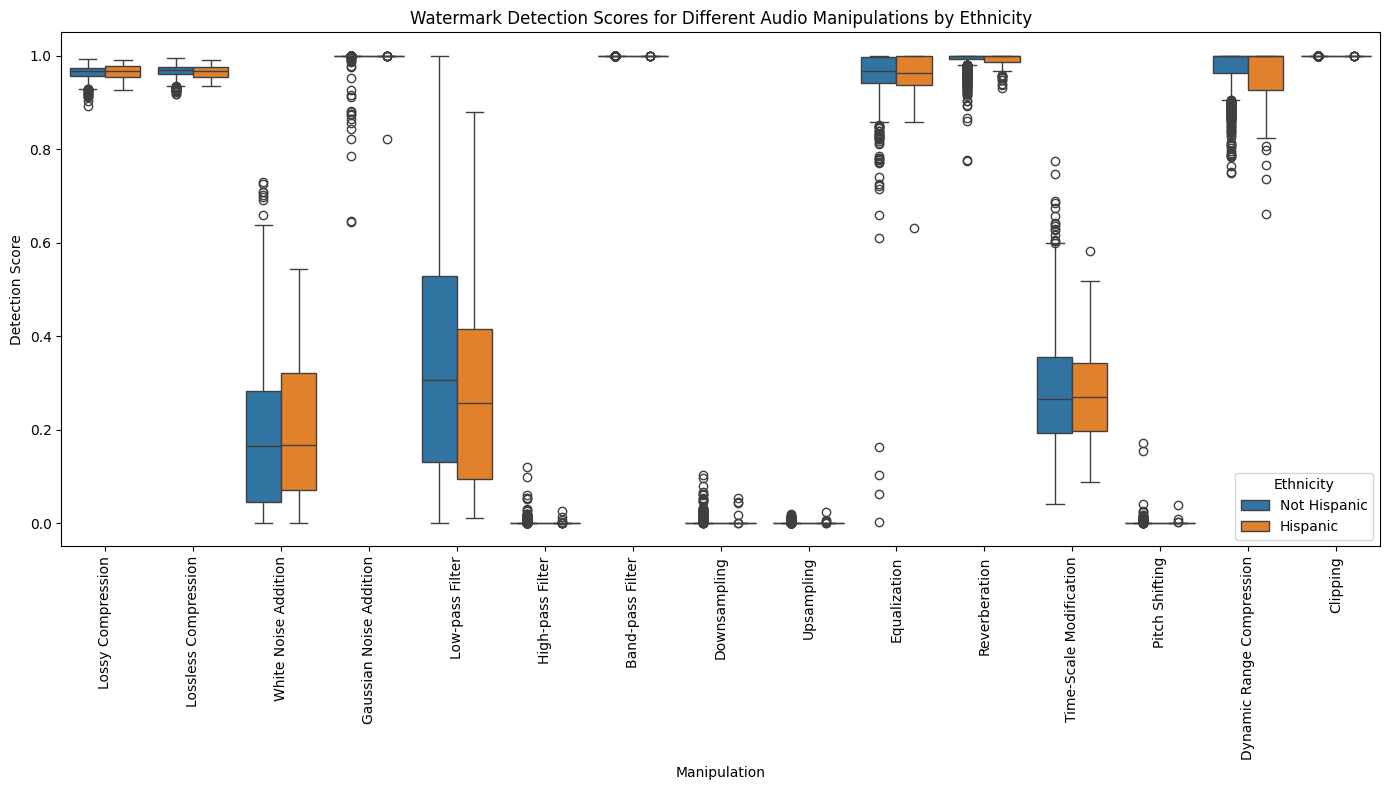

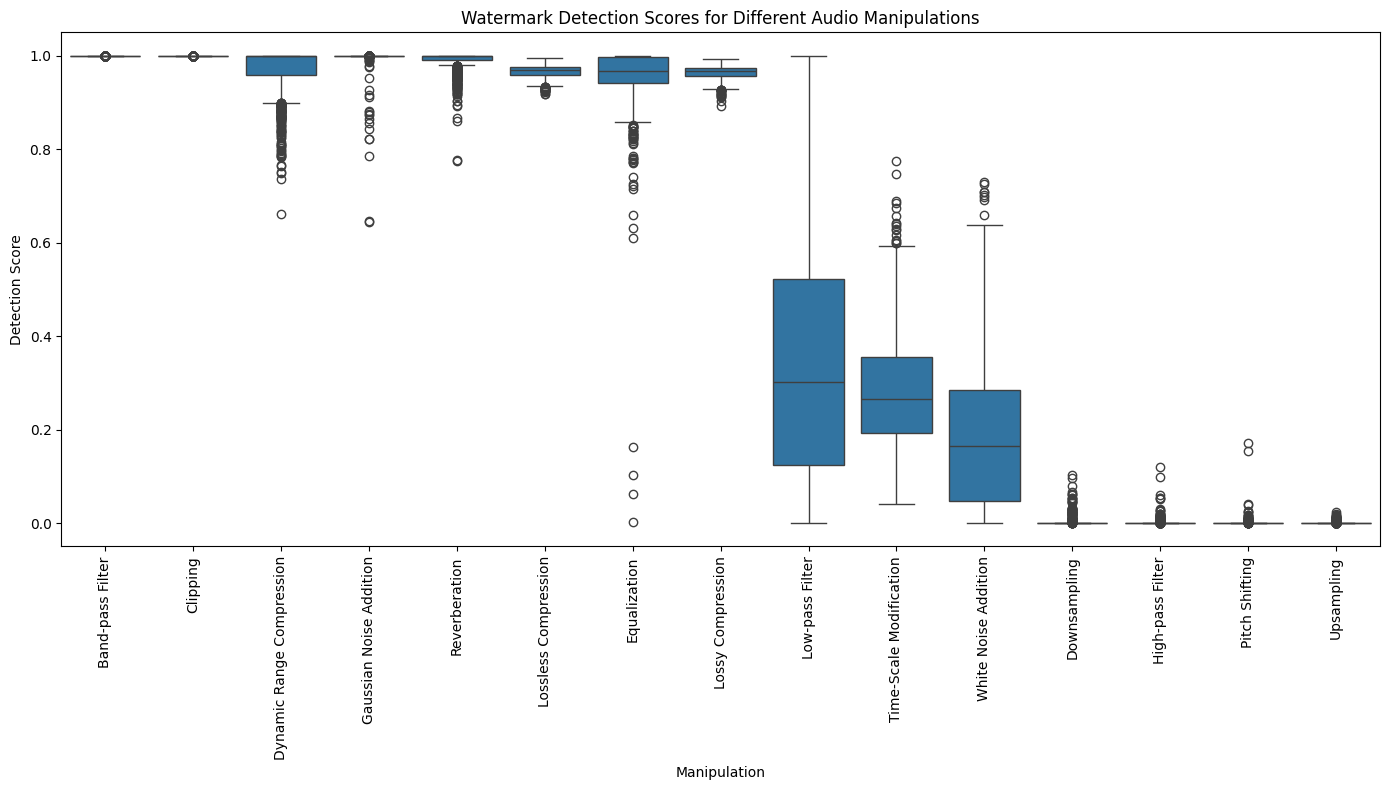

In [31]:
plot_results(experiment_results)